In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install torch==2.0.1+cu113 torchvision==0.15.2+cu113 torchaudio==2.0.1

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install torch torchvision torchaudio

In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - cudatoolkit=11.3

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from PIL import Image

In [3]:
print(torch.__version__)

2.3.1


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [ ]:
print(torch.cuda.get_device_name(0))

In [5]:
def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        index = 0
        img_dir = os.path.join(path, i)
        if not os.path.isdir(img_dir):
            continue
            
        for j in os.listdir(img_dir):
            dd["images"] += [os.path.join(img_dir, j)]
            dd["labels"] += [i]
            index += 1
            if index == 100:
                break


    return pd.DataFrame(dd)

train = create_df("/Users/keitasakurai/PycharmProjects/CDB/blood_cell_images")

index_label = dict()
label_index = dict()

for i, j in enumerate(train["labels"].unique()):
    index_label[i] = j
    label_index[j] = i

train["labels"] = train["labels"].map(label_index)

In [6]:
EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 224
BATCH = 32
OUT_SIZE = len(index_label)

In [7]:
class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):

        # img, label = self.data[x, 0], self.data[x, 1]
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        
        
        img = Image.open(img_path).convert("RGB")
        # img = np.array(img)
        img = self.transform(img)
        
        return img, label

# transforms.ToPILImage(),

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
train, val = train_test_split(train, random_state=42, test_size=0.2)
val, test = train_test_split(val, random_state=42, test_size=0.5)

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

# train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)

val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

In [9]:
# resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet = resnet50(weights=None)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)
        # return nn.functional.softmax(self.model(x), dim=1)

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model = ResNet(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [10]:
# best_model = deepcopy(model)
# best_model = deepcopy(model.cpu()).to(device)
best_model = model
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [11]:
img_path, label = train.iloc[0, 0], train.iloc[0, 1] 
print("Path:", img_path)
print("Exists:", os.path.exists(img_path))

Path: /Users/keitasakurai/PycharmProjects/CDB/blood_cell_images/erythroblast/ERB_630943.jpg
Exists: True


In [12]:
print(len(train_dl))

13


In [13]:
print(len(val_dl)) 

2


In [14]:
print(train_dl.batch_size)

32


In [15]:
print(f"Dataset size: {len(train_dl.dataset)}")

Dataset size: 400


In [16]:
print(type(train_dl.dataset))

<class '__main__.Pipeline'>


In [17]:
def train_one_epoch(model, train_dl, optimizer, criterion, device):
    model.train()
    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if device == "cuda":
            data, target = data.cuda(), target.cuda()
        # print(data.shape, target.shape)

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    return diff / total, acc / total

In [18]:
def validate(model, val_dl, criterion, device):
    model.eval()
    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            if device == "cuda":
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    return diff / total, acc / total


In [19]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
if device == "cuda":
    model = model.cuda()

for i in range(1, EPOCHS + 1):
    train_loss_epoch, train_acc_epoch = train_one_epoch(model, train_dl, optimizer, criterion, device)
    val_loss_epoch, val_acc_epoch = validate(model, val_dl, criterion, device)

    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print(f"Epoch {i} train loss {train_loss_epoch:.4f} acc {train_acc_epoch:.4f} val loss {val_loss_epoch:.4f} acc {val_acc_epoch:.4f}")

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1 train loss 0.4208 acc 0.2500 val loss 2.6184 acc 0.2000
Epoch 2 train loss 0.0765 acc 0.3300 val loss 730.0965 acc 0.2800
Epoch 3 train loss 0.1007 acc 0.4050 val loss 0.0837 acc 0.5400
Epoch 4 train loss 0.0582 acc 0.5200 val loss 0.0586 acc 0.3000
Epoch 5 train loss 0.0348 acc 0.6125 val loss 0.4629 acc 0.3200
Epoch 6 train loss 0.0316 acc 0.6950 val loss 1.8645 acc 0.2400
Epoch 7 train loss 0.0198 acc 0.7450 val loss 0.0687 acc 0.4200
Epoch 8 train loss 0.0169 acc 0.7600 val loss 0.0154 acc 0.8600
Epoch 9 train loss 0.0150 acc 0.7925 val loss 0.0229 acc 0.7200
Epoch 10 train loss 0.0128 acc 0.8500 val loss 0.0150 acc 0.8000


In [20]:
%matplotlib inline

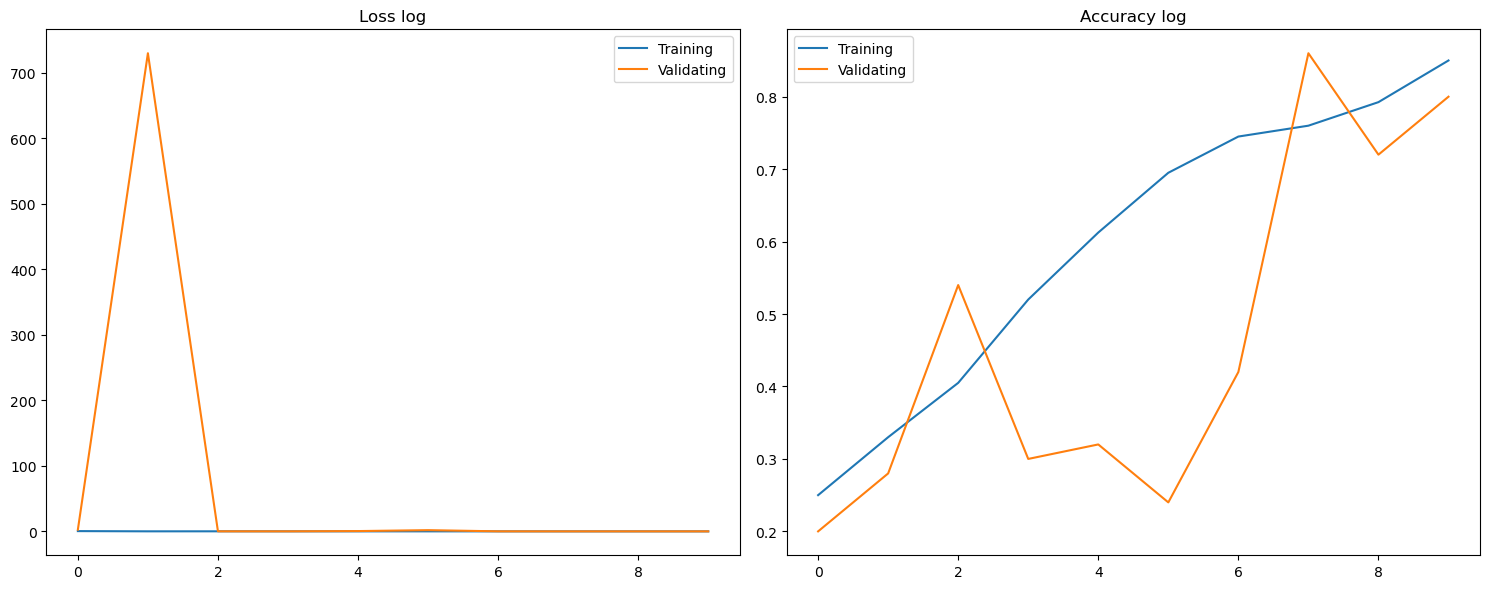

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].set_title("Loss log")
axes[index].legend()

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].set_title("Accuracy log")
axes[index].legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.98      0.98      0.98        50



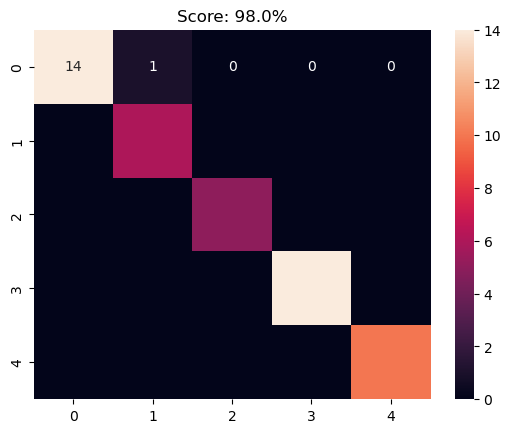

In [23]:
def predict(img):
    img = Image.open(img).convert("RGB")
    img = transform(np.array(img))
    img = img.view([1, 3, 224, 224])

    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

    index = out.argmax(1).item()

    return index, round(out[0][index].item()*100, 2)


truth = []
preds = []
probas = []

for i in range(test.shape[0]):
    truth += [test.iloc[i, 1]]
    pred, proba = predict(test.iloc[i, 0])
    preds += [pred]
    probas += [proba]

score = accuracy_score(preds, truth)
print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

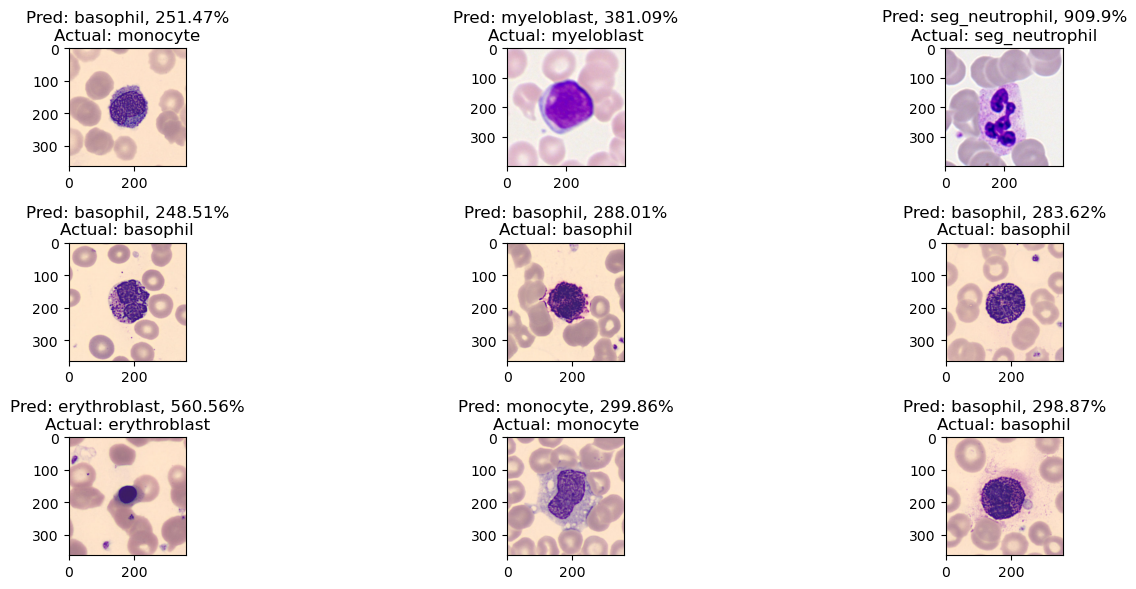

In [25]:
index = 0

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(Image.open(test.iloc[index, 0]).convert("RGB")))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(index_label[preds[index]], probas[index],
                                                                index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()